**Description:**

This is the Jupyter notebook is used for the machine learning part of the project. In this notebook the focus is on ensebmle methods, which are: Random Forest, AdaBoost and XGBoost

**Project Name:** Lending Club

**Team:** Silas Mederer, Jonas Bechthold

**Date:** 2020-10-02 to 2020-10-08

# Setting up & load data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [83]:
random_state = 100           # Ensures modeling results can be replicated
pd.set_option('display.max_columns', 50) # Sets maximum columns displayed in tables

Import our dataframae, which was exported after the EDA.

In [2]:
df = pd.read_csv('data/df_clean.csv')
df.drop("Unnamed: 0", inplace=True, axis=1)

In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41292 entries, 0 to 41291
Data columns (total 14 columns):
loan_amnt               41292 non-null float64
term_is_36              41292 non-null int64
int_rate                41292 non-null float64
grade                   41292 non-null object
sub_grade               41292 non-null object
emp_length              41292 non-null float64
annual_inc              41292 non-null float64
purpose                 41292 non-null object
addr_state              41292 non-null object
dti                     41292 non-null float64
inq_last_6mths          41292 non-null float64
open_acc                41292 non-null float64
pub_rec_bankruptcies    41292 non-null int64
default                 41292 non-null int64
dtypes: float64(7), int64(3), object(4)
memory usage: 4.4+ MB
None


In [110]:
# Function to plot confusion matrices

def scores(y_train, y_test, y_train_pred, y_pred, filename=str):
    
    sns.set(font_scale=1.5)
    print("Confusion matrix train")
    print(confusion_matrix(y_train, y_train_pred))

    print("Classification report train")
    print(classification_report(y_train, y_train_pred))

    # Figure test
    conf_mat = pd.crosstab(np.ravel(y_test), np.ravel(y_pred),
                           colnames=["Predicted"], rownames=["Actual"])
    sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt="g")

    plt.title('Confusion Matrix: Test Data')
    plt.savefig(
        f"plots/conf-matrix-test-{filename}.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    print("Confusion matrix test")
    print(confusion_matrix(y_test, y_pred))

    print("Classification report test")
    print(classification_report(y_test, y_pred))

    # Figure train
    conf_mat = pd.crosstab(np.ravel(y_train), np.ravel(y_train_pred),
                           colnames=["Predicted"], rownames=["Actual"])
    sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt="g")

    plt.title('Confusion Matrix: Training Data')
    plt.savefig(
        f"plots/conf-matrix-train-{filename}.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

## Upscaling of the minority class default = 1 and downscaling the majority class

First, we'll import the resampling module from Scikit-Learn:

In [4]:
from sklearn.utils import resample

Next, we'll create a new DataFrame with an up-sampled minority class and a down-sampled majority class. 

First, we'll separate observations from each class into different DataFrames, then we'll resample the minority and majority class with replacement. Finally, we'll combine the both sampled classes into a new DataFrame.

In [5]:
df.default.value_counts()

0    35006
1     6286
Name: default, dtype: int64

In [6]:
# Separate majority and minority classes
df_majority = df[df.default==0]
df_minority = df[df.default==1]

target_sample_size = 20000

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=target_sample_size,    # to match majority class
                                 random_state=random_state) # reproducible results

# Upsample minority class
df_majority_downsampled = resample(df_majority, 
                                 replace=True,     # sample with replacement
                                 n_samples=target_sample_size,    # to match majority class
                                 random_state=random_state) # reproducible results

df_minority_upsampled.default.value_counts(),df_majority_downsampled.default.value_counts()

(1    20000
 Name: default, dtype: int64,
 0    20000
 Name: default, dtype: int64)

In [7]:
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority_downsampled, df_minority_upsampled])
 
# Display new class counts
df_upsampled.default.value_counts()

1    20000
0    20000
Name: default, dtype: int64

In [8]:
df_upsampled.head()

,loan_amnt,term_is_36,int_rate,grade,sub_grade,emp_length,annual_inc,purpose,addr_state,dti,inq_last_6mths,open_acc,pub_rec_bankruptcies,default
18681,2100.0,1,0.1306,C,C2,4.0,72000.0,car,TX,0.1542,1.0,9.0,1,0
32785,8000.0,1,0.1496,D,D2,2.0,38000.0,debt_consolidation,NY,0.1033,1.0,14.0,0,0
20989,21250.0,1,0.0691,A,A5,10.0,51060.0,credit_card,IL,0.2456,0.0,5.0,0,0
18289,6000.0,1,0.1037,B,B3,4.0,40000.0,credit_card,CA,0.1992,1.0,19.0,0,0
9316,12000.0,1,0.0749,A,A4,0.0,60000.0,debt_consolidation,WA,0.1574,0.0,8.0,0,0


In [9]:
df_upsampled.shape

(40000, 14)

In [10]:
df_upsampled.columns

Index(['loan_amnt', 'term_is_36', 'int_rate', 'grade', 'sub_grade',
       'emp_length', 'annual_inc', 'purpose', 'addr_state', 'dti',
       'inq_last_6mths', 'open_acc', 'pub_rec_bankruptcies', 'default'],
      dtype='object')

## Create Dummies

In [11]:
cat_feats = ['grade','sub_grade','purpose','addr_state']

In [12]:
df = df_upsampled.copy()

In [13]:
df_final = pd.get_dummies(df, columns=cat_feats, drop_first=True)

In [14]:
df_final.head()

,loan_amnt,term_is_36,int_rate,emp_length,annual_inc,dti,inq_last_6mths,open_acc,pub_rec_bankruptcies,default,...,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY
18681,2100.0,1,0.1306,4.0,72000.0,0.1542,1.0,9.0,1,0,...,0,0,1,0,0,0,0,0,0,0
32785,8000.0,1,0.1496,2.0,38000.0,0.1033,1.0,14.0,0,0,...,0,0,0,0,0,0,0,0,0,0
20989,21250.0,1,0.0691,10.0,51060.0,0.2456,0.0,5.0,0,0,...,0,0,0,0,0,0,0,0,0,0
18289,6000.0,1,0.1037,4.0,40000.0,0.1992,1.0,19.0,0,0,...,0,0,0,0,0,0,0,0,0,0
9316,12000.0,1,0.0749,0.0,60000.0,0.1574,0.0,8.0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [15]:
df_final.shape

(40000, 112)

## Train Test Split

In [16]:
from sklearn.model_selection import train_test_split

X = df_final.drop('default', axis=1)
y = df_final['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

# Scaling

In [17]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()

scaling_list = ["dti", "int_rate", "loan_amnt","annual_inc"]
scaling_min_max = ["annual_inc"]

def logarithmize(value):
    logvalue = np.log(value)
    return logvalue

# scaling train
X_train[scaling_min_max] = X_train[scaling_min_max].apply(lambda x: logarithmize(x))
X_train[scaling_list] = scaler.fit_transform(X_train[scaling_list])

# scaling test with same scaling parameters
X_test[scaling_min_max] = X_test[scaling_min_max].apply(lambda x: logarithmize(x))
X_test[scaling_list] = scaler.transform(X_test[scaling_list])

/Users/jonasbechthold/opt/anaconda3/envs/nf/lib/python3.6/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/Users/jonasbechthold/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/jonasbechthold/opt/anaconda3/envs/nf/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

<AxesSubplot:>

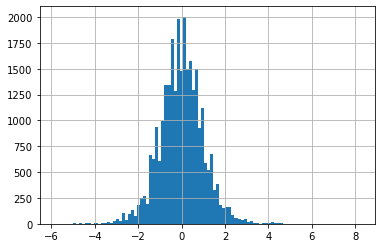

In [18]:
X_train.annual_inc.hist(bins=100)

<AxesSubplot:>

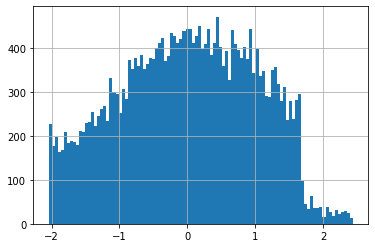

In [19]:
X_train.dti.hist(bins=100)

<AxesSubplot:>

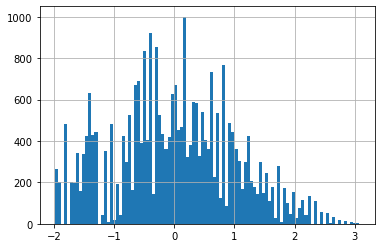

In [20]:
X_train.int_rate.hist(bins=100)

<AxesSubplot:>

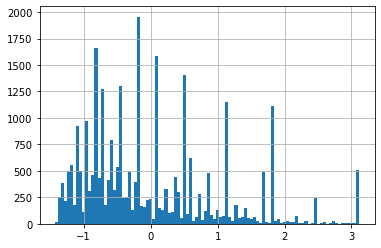

In [21]:
X_train.loan_amnt.hist(bins=100)

# Random Forest

In [31]:
from sklearn.ensemble import RandomForestClassifier

In [32]:
rnc = RandomForestClassifier()

In [33]:
rnc.fit(X_train, y_train)

RandomForestClassifier()

In [34]:
pred_train = rnc.predict(X_train)

In [35]:
pred_test = rnc.predict(X_test)

In [36]:
print(classification_report(y_train, pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13946
           1       1.00      1.00      1.00     14054

    accuracy                           1.00     28000
   macro avg       1.00      1.00      1.00     28000
weighted avg       1.00      1.00      1.00     28000



In [37]:
print(confusion_matrix(y_train, pred_train))

[[13946     0]
 [    0 14054]]


In [38]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.93      0.88      0.91      6054
           1       0.89      0.94      0.91      5946

    accuracy                           0.91     12000
   macro avg       0.91      0.91      0.91     12000
weighted avg       0.91      0.91      0.91     12000



In [39]:
print(confusion_matrix(y_test, pred_test))

[[5345  709]
 [ 379 5567]]


## Random Forest with Stacking - Future Work

In [ ]:
from sklearn.ensemble import StackingClassifier

clf = StackingClassifier(RandomForestClassifier(random_state=random_state))

clf.fit(X_train, y_train)

## Random Forest Optimization through RandomizedSearchCV

In [70]:
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameter grid
param_grid = {
    'n_estimators': np.linspace(10, 500,50).astype(int),
    'max_depth': [None] + list(np.linspace(3, 100).astype(int)),
    'max_features': ['auto', 'sqrt', None],
    'bootstrap': [True, False]
}

# Estimator for use in random search
estimator = RandomForestClassifier(random_state=random_state)

# Create the random search model
rnc = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'f1', cv = 5, 
                        n_iter = 50, verbose = -1)

# Fit 
rnc.fit(X_train, y_train)
best_model = rnc.best_estimator_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 36.7min finished


In [71]:
print(rnc.best_params_)
print(rnc.best_score_)

{'n_estimators': 240, 'max_features': 'sqrt', 'max_depth': 88, 'bootstrap': False}
0.8919803157797664


In [68]:
train_rf_predictions = best_model.predict(X_train)
train_rf_probs = best_model.predict_proba(X_train)[:, 1]

rf_predictions = best_model.predict(X_test)
rf_probs = best_model.predict_proba(X_test)[:, 1]

{'n_estimators': 270, 'max_features': 'auto', 'max_depth': 88, 'bootstrap': False}
0.8913923346742287


In [48]:
best_pred_train = best_model.predict(X_train)

In [49]:
best_pred_test = rnc.predict(X_test)

In [50]:
print(classification_report(y_train, best_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13946
           1       1.00      1.00      1.00     14054

    accuracy                           1.00     28000
   macro avg       1.00      1.00      1.00     28000
weighted avg       1.00      1.00      1.00     28000



In [52]:
print(confusion_matrix(y_train, best_pred_train))

[[13946     0]
 [    0 14054]]


In [53]:
print(classification_report(y_test, best_pred_test))

              precision    recall  f1-score   support

           0       0.93      0.80      0.86      6054
           1       0.82      0.94      0.87      5946

    accuracy                           0.87     12000
   macro avg       0.87      0.87      0.87     12000
weighted avg       0.87      0.87      0.87     12000



In [54]:
print(confusion_matrix(y_test, best_pred_test))

[[4835 1219]
 [ 376 5570]]


In [55]:
n_nodes = []
max_depths = []

for ind_tree in best_model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 8082
Average maximum depth 45


## Random Forest with optimized parameter - Score Recall

The best prameter of the optimization are the following:

{'n_estimators': 160, 'max_features': None, 'max_depth': 68, 'bootstrap': False}

In [104]:
rnc_opt = RandomForestClassifier(n_estimators=160, max_features=None,max_depth=68,bootstrap=False)
rnc_opt.fit(X_train,y_train)

opt_pred_train = rnc_opt.predict(X_train)
opt_pred_test = rnc_opt.predict(X_test)

print(classification_report(y_train, opt_pred_train))

print(confusion_matrix(y_train,opt_pred_train))

print(classification_report(y_test, opt_pred_test))

print(confusion_matrix(y_test, opt_pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13946
           1       1.00      1.00      1.00     14054

    accuracy                           1.00     28000
   macro avg       1.00      1.00      1.00     28000
weighted avg       1.00      1.00      1.00     28000

[[13946     0]
 [    0 14054]]
              precision    recall  f1-score   support

           0       0.93      0.80      0.86      6054
           1       0.82      0.94      0.88      5946

    accuracy                           0.87     12000
   macro avg       0.88      0.87      0.87     12000
weighted avg       0.88      0.87      0.87     12000

[[4854 1200]
 [ 376 5570]]


Confusion matrix train
[[13946     0]
 [    0 14054]]
Classification report train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13946
           1       1.00      1.00      1.00     14054

    accuracy                           1.00     28000
   macro avg       1.00      1.00      1.00     28000
weighted avg       1.00      1.00      1.00     28000



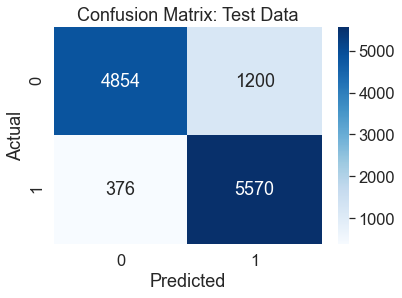

Confusion matrix test
[[4854 1200]
 [ 376 5570]]
Classification report test
              precision    recall  f1-score   support

           0       0.93      0.80      0.86      6054
           1       0.82      0.94      0.88      5946

    accuracy                           0.87     12000
   macro avg       0.88      0.87      0.87     12000
weighted avg       0.88      0.87      0.87     12000



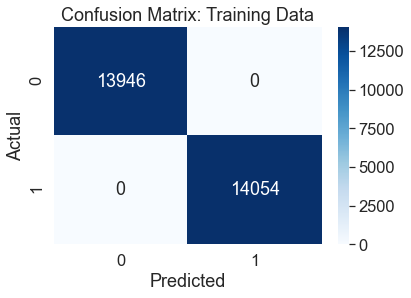

In [111]:
scores(y_train, y_test, opt_pred_train, opt_pred_test, filename='random_forest_recall_focus')

## Random Forest with optimized parameter - Score F1

The best prameter of the optimization are the following:

{'n_estimators': 270, 'max_features': 'auto', 'max_depth': 88, 'bootstrap': False}

In [69]:
rnc_opt = RandomForestClassifier(n_estimators=270, max_features='auto',max_depth=88,bootstrap=False)
rnc_opt.fit(X_train,y_train)

opt_pred_train = rnc_opt.predict(X_train)
opt_pred_test = rnc_opt.predict(X_test)

print(classification_report(y_train, opt_pred_train))

print(confusion_matrix(y_train,opt_pred_train))

print(classification_report(y_test, opt_pred_test))

print(confusion_matrix(y_test, opt_pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13946
           1       1.00      1.00      1.00     14054

    accuracy                           1.00     28000
   macro avg       1.00      1.00      1.00     28000
weighted avg       1.00      1.00      1.00     28000

[[13946     0]
 [    0 14054]]
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      6054
           1       0.92      0.93      0.93      5946

    accuracy                           0.93     12000
   macro avg       0.93      0.93      0.93     12000
weighted avg       0.93      0.93      0.93     12000

[[5591  463]
 [ 431 5515]]


# XGBoost


In [72]:
from xgboost import XGBClassifier

In [73]:
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier()

In [74]:
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

In [75]:
print(confusion_matrix(y_test, y_pred))

[[3994 2060]
 [1836 4110]]


In [76]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.66      0.67      6054
           1       0.67      0.69      0.68      5946

    accuracy                           0.68     12000
   macro avg       0.68      0.68      0.68     12000
weighted avg       0.68      0.68      0.68     12000



In [77]:
print(confusion_matrix(y_train, y_pred_train))

[[9291 4655]
 [4373 9681]]


In [78]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.68      0.67      0.67     13946
           1       0.68      0.69      0.68     14054

    accuracy                           0.68     28000
   macro avg       0.68      0.68      0.68     28000
weighted avg       0.68      0.68      0.68     28000



## XGBoost Optimization through Randomized SearchCV

In [79]:
from scipy import stats
from scipy.stats import randint
from sklearn.model_selection import KFold, StratifiedKFold, cross_validate, cross_val_score
from sklearn.model_selection import RandomizedSearchCV

clf_xgb = XGBClassifier()

param_dist = {'n_estimators': stats.randint(150, 1000),
              'learning_rate': stats.uniform(0.01, 0.6),
              'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
             }

clf = RandomizedSearchCV(clf_xgb, 
                         param_distributions = param_dist,
                         cv = 5,  
                         n_iter = 20,
                         scoring = 'f1', 
                         error_score = 0, 
                         verbose = -1, 
                         n_jobs = -1)

clf.fit(X_train, y_train)

best_score = clf.best_score_
best_params = clf.best_params_
print("Best score: {}".format(best_score))
print("Best params: ")
for param_name in sorted(best_params.keys()):
    print('%s: %r' % (param_name, best_params[param_name]))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 20.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 37.1min finished


Best score: 0.8738027006433452
Best params: 
learning_rate: 0.18373847549667507
max_depth: 9
n_estimators: 927


## XGBoost with optimized parameter - Score F1

The best prameter of the optimization are the following:

{'learning_rate': 0.18373847549667507, 'max_depth': 9, 'n_estimators': 927}

In [81]:
xgb_opt = XGBClassifier(learning_rate=0.18373847549667507, max_depth=9, n_estimators=927)
xgb_opt.fit(X_train,y_train)

xgb_opt_pred_train = xgb_opt.predict(X_train)
xgb_opt_pred_test = xgb_opt.predict(X_test)

print(classification_report(y_train, xgb_opt_pred_train))

print(confusion_matrix(y_train,xgb_opt_pred_train))

print(classification_report(y_test, xgb_opt_pred_test))

print(confusion_matrix(y_test, xgb_opt_pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13946
           1       1.00      1.00      1.00     14054

    accuracy                           1.00     28000
   macro avg       1.00      1.00      1.00     28000
weighted avg       1.00      1.00      1.00     28000

[[13946     0]
 [    0 14054]]
              precision    recall  f1-score   support

           0       0.93      0.86      0.90      6054
           1       0.87      0.94      0.90      5946

    accuracy                           0.90     12000
   macro avg       0.90      0.90      0.90     12000
weighted avg       0.90      0.90      0.90     12000

[[5197  857]
 [ 362 5584]]


Confusion matrix train
[[13946     0]
 [    0 14054]]
Classification report train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13946
           1       1.00      1.00      1.00     14054

    accuracy                           1.00     28000
   macro avg       1.00      1.00      1.00     28000
weighted avg       1.00      1.00      1.00     28000



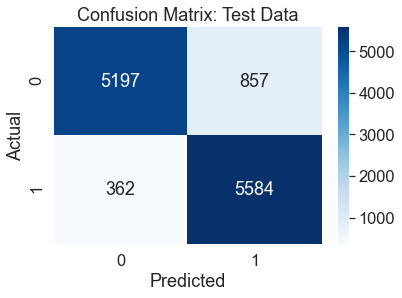

Confusion matrix test
[[5197  857]
 [ 362 5584]]
Classification report test
              precision    recall  f1-score   support

           0       0.93      0.86      0.90      6054
           1       0.87      0.94      0.90      5946

    accuracy                           0.90     12000
   macro avg       0.90      0.90      0.90     12000
weighted avg       0.90      0.90      0.90     12000



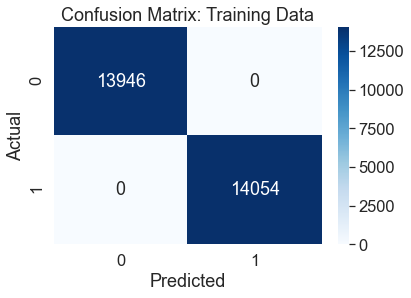

In [112]:
scores(y_train, y_test, xgb_opt_pred_train, xgb_opt_pred_test, filename='xgboost')

# AdaBoost

In [99]:
from sklearn.ensemble import AdaBoostClassifier

# fit model no training data
ada = AdaBoostClassifier(random_state = random_state)
ada.fit(X_train, y_train)

y_pred = ada.predict(X_test)
y_pred_train = ada.predict(X_train)

print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))

print(confusion_matrix(y_train, y_pred_train))

print(classification_report(y_train, y_pred_train))

[[3936 2118]
 [1962 3984]]
              precision    recall  f1-score   support

           0       0.67      0.65      0.66      6054
           1       0.65      0.67      0.66      5946

    accuracy                           0.66     12000
   macro avg       0.66      0.66      0.66     12000
weighted avg       0.66      0.66      0.66     12000

[[9114 4832]
 [4665 9389]]
              precision    recall  f1-score   support

           0       0.66      0.65      0.66     13946
           1       0.66      0.67      0.66     14054

    accuracy                           0.66     28000
   macro avg       0.66      0.66      0.66     28000
weighted avg       0.66      0.66      0.66     28000



## AdaBoost Optimization with RandomizedSearchCV

In [100]:
ada = AdaBoostClassifier(random_state=random_state)
parameters = {'n_estimators':[50, 100, 200, 500, 1000, 1500, 2000], 
              'learning_rate':[0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 0.75, 1.0]}

ada_obj = RandomizedSearchCV(ada, 
                            param_distributions=parameters, 
                            scoring = 'f1', 
                            cv = 5,
                            n_iter = 10,
                            random_state=random_state,
                            verbose=-1,
                            n_jobs = -1)

ada_fit = ada_obj.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  6.8min finished


In [101]:
print(ada_fit.best_params_)
print(ada_fit.best_score_)

{'n_estimators': 50, 'learning_rate': 0.05}
0.6679904914134471


## AdaBoost with optimized parameter - Score F1

The best prameter of the optimization are the following:

{'n_estimators': 50, 'learning_rate': 0.05}

In [102]:
ada_opt = AdaBoostClassifier(random_state=random_state,n_estimators=50,learning_rate=0.05)

ada_opt.fit(X_train,y_train)

ada_opt_pred_train = ada_opt.predict(X_train)
ada_opt_pred_test = ada_opt.predict(X_test)

print(classification_report(y_train, ada_opt_pred_train))

print(confusion_matrix(y_train, ada_opt_pred_train))

print(classification_report(y_test, ada_opt_pred_test))

print(confusion_matrix(y_test, ada_opt_pred_test))

              precision    recall  f1-score   support

           0       0.66      0.55      0.60     13946
           1       0.62      0.72      0.67     14054

    accuracy                           0.64     28000
   macro avg       0.64      0.64      0.64     28000
weighted avg       0.64      0.64      0.64     28000

[[ 7693  6253]
 [ 3879 10175]]
              precision    recall  f1-score   support

           0       0.67      0.55      0.60      6054
           1       0.61      0.73      0.66      5946

    accuracy                           0.64     12000
   macro avg       0.64      0.64      0.63     12000
weighted avg       0.64      0.64      0.63     12000

[[3306 2748]
 [1632 4314]]


Confusion matrix train
[[ 7693  6253]
 [ 3879 10175]]
Classification report train
              precision    recall  f1-score   support

           0       0.66      0.55      0.60     13946
           1       0.62      0.72      0.67     14054

    accuracy                           0.64     28000
   macro avg       0.64      0.64      0.64     28000
weighted avg       0.64      0.64      0.64     28000



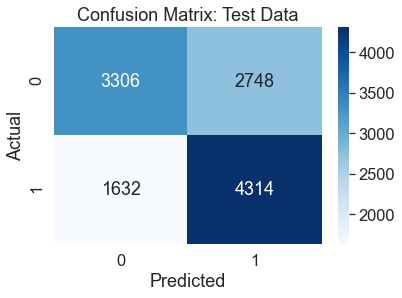

Confusion matrix test
[[3306 2748]
 [1632 4314]]
Classification report test
              precision    recall  f1-score   support

           0       0.67      0.55      0.60      6054
           1       0.61      0.73      0.66      5946

    accuracy                           0.64     12000
   macro avg       0.64      0.64      0.63     12000
weighted avg       0.64      0.64      0.63     12000



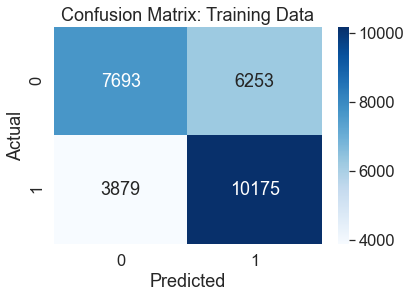

In [113]:
scores(y_train, y_test, ada_opt_pred_train, ada_opt_pred_test, filename='adaboost')